## Triangulating to the data distribution using model scores or error estimates

In the [previous notebook](./3 - Estimating model predictive capacity.ipynb), we estimated the extent to which models of this form are able to estimate values close to each of the given data points. This information can be used to recompute the interpolation while providing meaningful values to the weights in the least squares fit.

The `SSRFPACK` routines expect a weight for each point *in the grid* that determines how aggressively the spline fit should attempt to conform to the value at that point. A value close to zero effectively drops that point from the interpolation altogether. 

We added to the original dataset the following measures:

  - Mean error (`mean_err`) which is the mean error at each data point of all the predictions of the different model realisations at that point. 
  
  - Min error (`min_err`) which is the smallest absolute error at each data point for any of the models that were run.
  
  - Variance (`variance`) is the variance of the different model runs 


In [1]:
import os.path as path
import stripy as stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import litho1pt0

import gdal

In [2]:
## Define starting grid

grid1r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True, refinement_levels=4, tree=True)

## Drop points outside the region of interest

angles = grid1r.angular_separation( grid1r.lons, grid1r.lats, np.radians(-158.0) * np.ones_like(grid1r.lons), 
                                   np.radians(62.0) * np.ones_like(grid1r.lats) ) 

nodes = np.where(angles < np.radians(20.0))

grid1 = stripy.sTriangulation(grid1r.lons_map_to_wrapped(grid1r.lons[nodes])%(2.0*np.pi), grid1r.lats[nodes], permute=True)


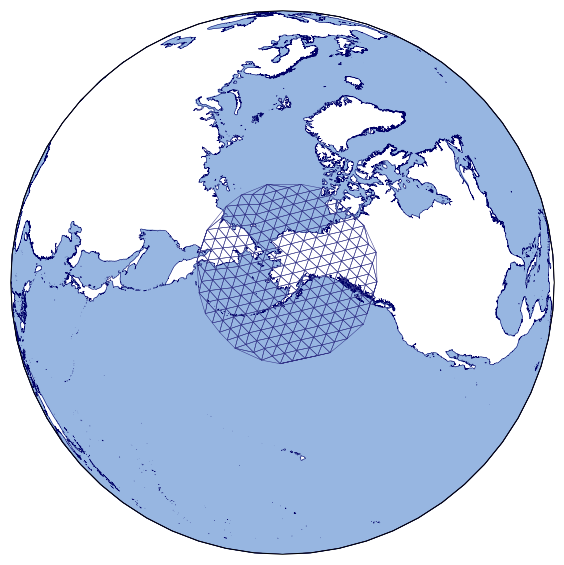

In [3]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=-160, central_latitude=60))
# ax  = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=-160))

ax.set_extent([-175,-130,50,72])
ax.set_global()
global_extent = [-180,180,-90,90]

grid = grid1

ax.coastlines(resolution="10m",color="#000066", linewidth=0.5)
ax.add_feature(cartopy.feature.OCEAN)


lons0 = np.degrees(grid.lons)
lats0 = np.degrees(grid.lats)

## Triangulation

for tri in grid1.simplices: 
    ax.plot( [lons0[tri[0]], lons0[tri[1]], lons0[tri[2]], lons0[tri[0]]],
             [lats0[tri[0]], lats0[tri[1]], lats0[tri[2]], lats0[tri[0]]],
             linewidth=0.5,
             color="#333388", transform=ccrs.PlateCarree(), zorder=2 )


In [4]:
## Assuming the previous notebook was run, read in the data ...

Moho_data_filename="AlaskaMohoErrs"
data = np.load("Models/{}.npz".format(Moho_data_filename))
moho_data_all = data['alaska_moho']

datagrid = stripy.sTriangulation(np.radians(moho_data_all['lon']),
                                 np.radians(moho_data_all['lat']), 
                                 permute=True, tree=False)


In [5]:
targets_p1 = [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13, 15, 20, 30]
targets_p2 = [0.05, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 , 1.0, 1.2, 1.4, 1.6, 2.0, 3.0, 4.0, 5.0]

targets_p1 = [50, 75, 100, 125, 150, 175, 200, 225, 250, 300, 350]
targets_p2 = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 7.5, 10.0, 15.0]

## Build several triangulations for testing

Let $p_1$ be the free parameter (the target nodal weight) for the mesh and obtain meshes for a range of values of this parameter. 

The meshes are constructed with the function `refine_grid_to_target_points` which refines an initial, coarse triangulation iteratively until the target condition defined by $p_1$ and a minimum-area constraint are met.

A strategy for mapping the data points to the mesh is required, and in this case, we use the barycentric coordinates of the points within each simplex to attribute a fraction of the data value to each of the nodes of the simplex. The normalisation is done node-by-node by summation of the weights of all the data points contributing to a node. 

In [6]:


def weighted_average_to_nodes(lons, lats, data, interpolator ):
    
    grid   = np.zeros(interpolator.npoints)
    norm   = np.zeros(interpolator.npoints)
    count  = np.zeros(interpolator.npoints, dtype=np.int)

    bcc, nodes = interpolator.containing_simplex_and_bcc(lons, lats)

    # Beware vectorising the reduction operation !!
    
    for i in range(0, len(data)):
        

        grid[nodes[i][0]] += bcc[i][0] * data[i]
        grid[nodes[i][1]] += bcc[i][1] * data[i]
        grid[nodes[i][2]] += bcc[i][2] * data[i]

        norm[nodes[i][0]] += bcc[i][0]
        norm[nodes[i][1]] += bcc[i][1]
        norm[nodes[i][2]] += bcc[i][2]
        
        count[nodes[i][0]] += 1
        count[nodes[i][1]] += 1
        count[nodes[i][2]] += 1
        

    grid[np.where(norm > 1.0e-18)] /= norm[np.where(norm > 1.0e-18)]
    norm[np.where(norm <=1.0e-18)] = 0.0
   
    return grid, norm, count

## For efficiency, this routine will average the data and the error measure
## from the scattered points to the nodes using barycentric coordinates.

def weighted_average_to_nodes2(lons, lats, data, data2, interpolator ):
    
    grid   = np.zeros(interpolator.npoints)
    grid2  = np.zeros(interpolator.npoints)
    norm   = np.zeros(interpolator.npoints)
    count  = np.zeros(interpolator.npoints, dtype=np.int)

    bcc, nodes = interpolator.containing_simplex_and_bcc(lons, lats)

    # Beware vectorising the reduction operation !!
    
    for i in range(0, len(data)):
        
        grid[nodes[i][0]] += bcc[i][0] * data[i]
        grid[nodes[i][1]] += bcc[i][1] * data[i]
        grid[nodes[i][2]] += bcc[i][2] * data[i]
        
        grid2[nodes[i][0]] += bcc[i][0] * data2[i]
        grid2[nodes[i][1]] += bcc[i][1] * data2[i]
        grid2[nodes[i][2]] += bcc[i][2] * data2[i]

        norm[nodes[i][0]] += bcc[i][0]
        norm[nodes[i][1]] += bcc[i][1]
        norm[nodes[i][2]] += bcc[i][2]
        
        count[nodes[i][0]] += 1
        count[nodes[i][1]] += 1
        count[nodes[i][2]] += 1
        
    grid[np.where(norm > 1.0e-18)] /= norm[np.where(norm > 1.0e-18)]
    norm[np.where(norm <=1.0e-18)] = 0.0
    
    return grid, grid2, norm, count

In [7]:
def refine_grid_to_target_points_1(lons, lats, grid1, target_value ):

    grids = [grid1]
    
    target = target_value

    for i in range(0, 20):

        ## First refine

        ave, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), np.ones_like(lats), grids[-1])

        node_area = np.zeros(grids[-1].npoints)
        t_areas = grids[-1].areas()

        for t,simplex in enumerate(grids[-1].simplices):
            node_area[simplex] += t_areas[t] 

        node_area /= node_area.max()

        ## Conditions on weighted average & min area 
        
        vertices = np.where(np.logical_and(norm > target, node_area > 0.0001))[0]

        if vertices.shape[0] != 0: 
            newlons, newlats = grids[-1].centroid_refine_triangulation_by_vertices(vertices=vertices)
            rgrid = stripy.sTriangulation(newlons, newlats, permute=False)
            grids.append(rgrid)

        else:        
            break

    # Needs a final update 
    ave, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), np.ones_like(lats), grids[-1])
    return grids[-1], norm

## Build grids for each target p1 value

def refine_grid_to_target_points(lons, lats, target_value ):
       
    from scipy.cluster.vq import kmeans, kmeans2, whiten
    
    xyz = np.array(stripy.spherical.lonlat2xyz(np.radians(lons), np.radians(lats))).T   
    xyzk,k = kmeans2(xyz, target_value, minit="random")
    xyzk_norm = xyzk / np.sqrt((xyzk**2).sum(axis=1)).reshape(-1,1)
    newlons, newlats = stripy.spherical.xyz2lonlat(xyzk_norm[:,0], xyzk_norm[:,1], xyzk_norm[:,2])
    
    grid = stripy.sTriangulation(lons=newlons, lats=newlats, permute=True, tree=True)
    
    # Needs a final update 
    ave, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), np.ones_like(lats), grid)
    return grid, norm


## Build MANY grids for each target p1 value

grid_realisations = 250
grid_ensemble=[]
norms_ensemble=[]

for i in range(0, grid_realisations):
    
    print i
    
    adapted_grids = {}
    grid_norm = {}

    ## Poor clustering produces "NaN" in grid_norm ... repeat until it works !!! 

    for p1 in targets_p1:
        success = False
        count = 0
        while not success:
            count += 1
            if count%10 ==0:
                print("Still attempting to find a good grid for p1 = {} after {} tries".format(p1, count))
            adapted_grids[p1], grid_norm[p1] = refine_grid_to_target_points(moho_data_all['lon'], moho_data_all['lat'], p1)
            if not np.isnan(grid_norm[p1].min()):
                try:
                    adapted_grids[p1].smoothing(np.random.rand(p1), np.ones(p1), 1.0, 0.5, 0.1)
                    success = True
                    print("{} attempts required to obtain a reasonable grid for p1 = {}".format(count, p1))
                except:
                    success = False

        grid_ensemble.append(adapted_grids)
        norms_ensemble.append(grid_norm)
            
    

0
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
2 attempts required to obtain a reasonable grid for p1 = 350
1
1 attempts required to obtain a reasonable grid for p1 = 50
2 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125


/usr/local/lib/python2.7/site-packages/scipy/cluster/vq.py:523: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python2.7/site-packages/stripy/spherical.py:694: RuntimeWarning: invalid value encountered in divide
  bcc /= bcc.sum(axis=1).reshape(-1,1)
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
2
1 attempts required to obtain a reasonable grid for p1 = 50
3 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
2 attempts required to o

2 attempts required to obtain a reasonable grid for p1 = 350
15
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
2 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
16
2 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
2 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to

1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
2 attempts required to obtain a reasonable grid for p1 = 350
28
2 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
29
3 attempts required to obtain a reasonable grid for p1 = 50
2 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to

2 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
2 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
42
2 attempts required to obtain a reasonable grid for p1 = 50
2 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
2 attempts required to o

1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
2 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
55
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
2 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
2 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
3 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to 

1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
68
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to 

1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
2 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
2 attempts required to obtain a reasonable grid for p1 = 350
81
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
2 attempts required to ob

1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
94
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
3 attempts required to obtain a reasonable grid for p1 = 125
3 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
4 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to 

2 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
107
2 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
108
1 attempts require

3 attempts required to obtain a reasonable grid for p1 = 350
120
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
121
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required 

1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
2 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
134
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
2 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to o

1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
146
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
2 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
2 attempts required to obtain a reasonable grid for p1 = 350
147
2 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required 

1 attempts required to obtain a reasonable grid for p1 = 100
2 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
4 attempts required to obtain a reasonable grid for p1 = 350
159
2 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to

2 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
172
2 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
2 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to

1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
184
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
2 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
185
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
2 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required 

1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
198
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
2 attempts required to

1 attempts required to obtain a reasonable grid for p1 = 350
210
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
211
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required 

1 attempts required to obtain a reasonable grid for p1 = 350
223
2 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
2 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
224
1 attempts required to obtain a reasonable grid for p1 = 50
2 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required 

1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to obtain a reasonable grid for p1 = 350
237
1 attempts required to obtain a reasonable grid for p1 = 50
1 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
2 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
1 attempts required to

1 attempts required to obtain a reasonable grid for p1 = 350
249
1 attempts required to obtain a reasonable grid for p1 = 50
2 attempts required to obtain a reasonable grid for p1 = 75
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
1 attempts required to obtain a reasonable grid for p1 = 300
2 attempts required to obtain a reasonable grid for p1 = 350


In [8]:
## This is a smooth version of the gridded data - the smoothing operator is taken from ssrfpack 
## The weights indicate the confidence in the data. For points that have few constraints, the weight 
## might well be lower but, perhaps, the variance should also play a role ... 

def compute_smoothed_solutions(goodgrid, gnorm, weight, data, a1):

    weights = 0.01 + gnorm
    ave = data

    smooth_d = goodgrid.smoothing(ave, weights, a1*goodgrid.npoints, 0.5, 0.001)

    return smooth_d


In [9]:
def partition_data(val=0.8):
    
    test = np.random.random(moho_data_all.shape[0]) > val
    training = ~test

    moho_data = moho_data_all[training]
    moho_data_test = moho_data_all[test]

    return moho_data, moho_data_test

In [10]:
def data_model(e, p1, p2, moho_data, moho_data_test):
    """
    p1 -> target parameter in adaptive triangulation
    p2 -> smoothing parameter (should be a list / array as this does not require re-triangulation)
    """
    
    import litho1pt0
    
    grid = grid_ensemble[e][p1]
    
    ## This information all changes when the data is subsampled
    

    ave, error, gnorm, count = weighted_average_to_nodes2(np.radians(moho_data['lon']), 
                                                  np.radians(moho_data['lat']), 
                                                  moho_data['moh'], np.abs(moho_data['q_score']),
                                                  grid)

    
    ## If we have no information for a location in the grid for this partitioning of the
    ## data, then we fill from litho 1.0 - the weight associated with these points
    ## is low and should not influence the surrounding values

    unconstrained_locations = np.where(gnorm < 1.0e-5)[0]
        
    if unconstrained_locations.shape[0] != 0:
        unknown_lons_deg = np.degrees(grid.lons[unconstrained_locations])%360.0
        unknown_lats_deg = np.degrees(grid.lats[unconstrained_locations])
    
        c2 = litho1pt0.layer_depth(lon=unknown_lons_deg, lat=unknown_lats_deg, layerID="LID-TOP")
        c1 = litho1pt0.layer_depth(lon=unknown_lons_deg, lat=unknown_lats_deg, layerID="CRUST1-TOP")

        ave[unconstrained_locations] = (c2-c1) * 0.001 ## Convert to km

# We can use the "scoring" of the data points to provide a point-by-point weight 
# for the interpolation algorithm 

    if unconstrained_locations.shape[0] != 0:
        error[unconstrained_locations] = 0.0
    
    enorm = error
    
# Error measure needs to be inverted to serve as the smoothing quality parameters
    #    if unconstrained_locations.shape[0] != 0:
    #     error[unconstrained_locations] = 10.0
    #     enorm = 1.0/error

         
    try:
        predictor, deriv = compute_smoothed_solutions(grid, enorm, 1.0, ave, p2)
        failed = 0
    except:
#         print("Cannot compute accurate smooth solution for p1 = {}, p2 = {}".format(p1, p2))
#         predictor, deriv = compute_smoothed_solutions(grid, enorm, 0.1, ave, 0.01)
#         failed = 1
        
        print("Cannot compute accurate smooth solution for p1 = {}, p2 = {}".format(p1, p2))
        predictor = np.zeros(grid.npoints)
        deriv = np.zeros((grid.npoints,3))
        failed = 1



 
    ## This is a measure of how well the model fits the test data points
    
    smooth_data_prediction, e0 = grid.interpolate(np.radians(moho_data_test['lon']),
                                                   np.radians(moho_data_test['lat']), 
                                                   predictor, order=3) 
    
    err = np.sqrt(((smooth_data_prediction - moho_data_test['moh'])**2).sum() / moho_data_test.shape[0])
    
        
    ## This is a measure of how well the model fits the points that it fits
    

    smooth_data_reconstruction, e0 = grid.interpolate(np.radians(moho_data['lon']),
                                                        np.radians(moho_data['lat']), predictor, order=3)
    
    err1 = np.sqrt(((smooth_data_reconstruction - moho_data['moh'])**2).sum() / moho_data.shape[0])


    return err, err1, err / err1, predictor, deriv
 



In [11]:
# target_p1 = 50
# target_p2 = 10.0
# moho_data, moho_data_test = partition_data(0.75)
# data_model(target_p1, target_p2, moho_data, moho_data_test)

In [12]:

## Make a partitioning of the data, then save the error information for each triangulation / smoother setting. 

loops = grid_realisations

## Find the best p1, p2 for each bisection of the data

err1 = np.zeros((loops, len(targets_p1), len(targets_p2)))
err2 = np.zeros((loops, len(targets_p1), len(targets_p2)))
errR = np.zeros((loops, len(targets_p1), len(targets_p2)))

for e in range(0,loops):
    
    if e%5 == 0:
        print("Partioning no {}".format(e))
        
    moho_data, moho_data_test = partition_data(np.random.random()*0.15+0.75)

    for i, target_p1 in enumerate(targets_p1):
        for j, target_p2 in enumerate(targets_p2):
            
            # print e, i, j 
     
            e1, e2, eR, predictor, deriv = data_model(e,target_p1, target_p2, moho_data, moho_data_test)
            err1[e,i,j] = e1
            err2[e,i,j] = e2
            errR[e,i,j] = eR
        
        

Partioning no 0
Partioning no 5
Partioning no 10
Partioning no 15
Partioning no 20
Partioning no 25
Partioning no 30
Partioning no 35
Cannot compute accurate smooth solution for p1 = 125, p2 = 0.1
Cannot compute accurate smooth solution for p1 = 125, p2 = 0.1
Partioning no 40
Cannot compute accurate smooth solution for p1 = 125, p2 = 0.1
Cannot compute accurate smooth solution for p1 = 125, p2 = 1.0
Partioning no 45
Partioning no 50
Partioning no 55
Partioning no 60
Partioning no 65
Cannot compute accurate smooth solution for p1 = 350, p2 = 0.1
Cannot compute accurate smooth solution for p1 = 350, p2 = 0.5
Cannot compute accurate smooth solution for p1 = 350, p2 = 0.1
Cannot compute accurate smooth solution for p1 = 350, p2 = 0.5
Cannot compute accurate smooth solution for p1 = 350, p2 = 0.1
Cannot compute accurate smooth solution for p1 = 350, p2 = 0.5
Partioning no 70
Cannot compute accurate smooth solution for p1 = 350, p2 = 0.1
Cannot compute accurate smooth solution for p1 = 350, 

In [13]:
## Statistics on these meshes

err1min = err1.min(axis=0)

err1m = err1.mean(axis=0)
err2m = err2.mean(axis=0)

err1c = err1.copy()
err1c[err2 < 0.0] = err1c.max()
err1c.sort(axis=0)

# errSm = err1m.copy()
# errSm[err2m < 0.0] = err1m.max()
errSm = (err1m + err2m) * 0.5

med1   = err1c[err1c.shape[0]/2,:,:]
uqart1 = err1c[err1c.shape[0]/4,:,:]

var1  = ((err1c - err1m)**2).mean(axis=0)

print targets_p1
print targets_p2
print errSm.min(), errSm.max()
print uqart1.min(), med1.min(), err1m.min()
print var1.min(), var1.max()

[50, 75, 100, 125, 150, 175, 200, 225, 250, 300, 350]
[0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 7.5, 10.0, 15.0]
6.257818564540468 8.930389003044853
6.559413508721252 7.127183850235063 7.094787857270135
0.4807044847363362 66.16840160052368


In [14]:
print err1m.min(), err1m.max()
print err2m.min(), err2m.max()
print errSm.min(), errSm.max()
print med1.min(),  med1.max()

7.094787857270135 10.20964651873851
5.0890105785909325 7.651131487351198
6.257818564540468 8.930389003044853
7.127183850235063 7.965440151095918


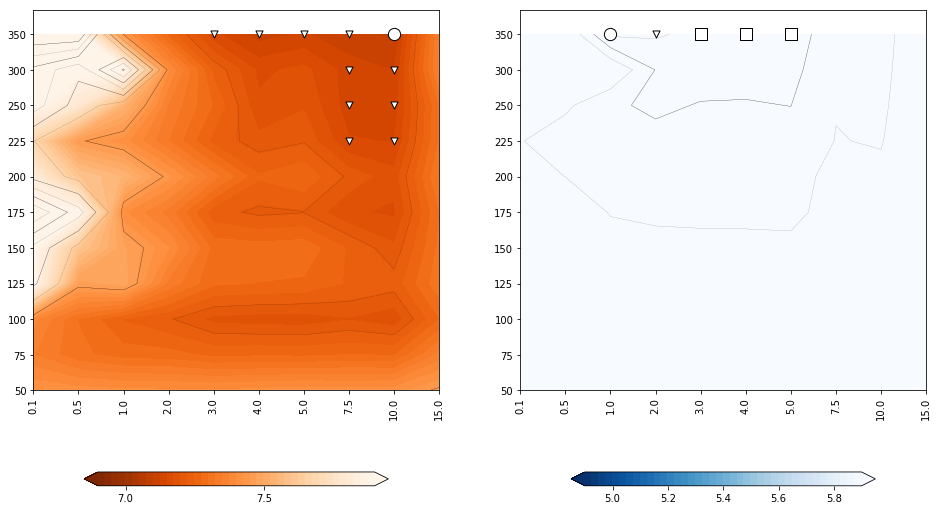

In [34]:

fig = plt.figure(figsize=(16, 10), facecolor=None)

ax1  = plt.subplot(121)

plt.xticks(np.arange(len(targets_p2)), targets_p2, rotation=90.0)
plt.yticks(np.arange(len(targets_p1)), targets_p1, rotation=0.0)

m1 = ax1.contourf(np.clip(err1m, 6.9, 7.9), cmap=plt.cm.Oranges_r, 
                  extend='both',
                  levels = np.linspace(6.9, 7.9, 41))

ax1.contour(np.clip(err1m, 7.0, 9.0), 
                 extend='both', linewidths=0.25, 
                 linestyles=[":","-"],
                 colors="#000000",
                 levels = np.linspace(7.0, 9.0, 10))

plt.colorbar(mappable=m1, ax=ax1, shrink=0.75,
             ticks=[7.0, 7.5, 8.0, 8.5, 9.0],
             orientation='horizontal')


optps = np.argwhere(err1m <  1.01 * (err1m).min())

for e in range (0,optps.shape[0]):
    ax1.scatter(optps[e][1], optps[e][0], 
                s=50, edgecolor="Black",
                color="#FFFFFF", marker="v", zorder=10)

optps = np.argwhere(err1m == (err1m).min())
for e in range (0,optps.shape[0]):
    ax1.scatter(optps[e][1], optps[e][0], s=150, 
                edgecolor="Black",
                color="#FFFFFF", marker="o", zorder=11)
    
    
optps = np.argwhere(np.logical_and(err1m <  1.01 * (err1m).min(), errSm < 1.0125 *  errSm.min()))

for e in range (0,optps.shape[0]):
    ax1.scatter(optps[e][1], optps[e][0], 
                s=150, edgecolor="Black",
                color="#FFFFFF", marker="s", zorder=9)


## Sharp-biased error
    
ax2  = plt.subplot(122)

plt.xticks(np.arange(len(targets_p2)), targets_p2, rotation=90.0)
plt.yticks(np.arange(len(targets_p1)), targets_p1, rotation=0.0)

m2 = ax2.contourf(np.clip(errSm,4.9,6.9), cmap=plt.cm.Blues_r, 
                  extend='both',
                  levels = np.linspace(4.9, 5.9, 41))

ax2.contour(np.clip(errSm, 4.9, 6.9), 
                 extend='both', linewidths=0.25, 
                 linestyles=[":","-"],
                 colors="#000000",
                 levels = np.linspace(4.9, 6.9, 11))


plt.colorbar(mappable=m2, ax=ax2, shrink=0.75,
             ticks=[5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6],
            orientation='horizontal')

optps = np.argwhere(errSm <  1.0125 * (errSm).min())
for e in range (0,optps.shape[0]):
    ax2.scatter(optps[e][1], optps[e][0], 
                s=50, edgecolor="Black",
                color="#FFFFFF", marker="v", zorder=9)

optps = np.argwhere(errSm == (errSm).min())
for e in range (0,optps.shape[0]):
    ax2.scatter(optps[e][1], optps[e][0], 
                s=150, edgecolor="Black",
                color="#FFFFFF", marker="o", zorder=10)

    
optps = np.argwhere(np.logical_and(err1m <  1.01 * (err1m).min(), errSm < 1.03 *  errSm.min()))

for e in range (0,optps.shape[0]):
    ax2.scatter(optps[e][1], optps[e][0], 
                s=150, edgecolor="Black",
                color="#FFFFFF", marker="s", zorder=8)


plt.savefig("Images/{}-ErrorPlot-p1p2.png".format(Moho_data_filename), dpi=300)

In [16]:
## A selection of results that are close to the best one

## Note the mean / median / upper quartile selections are the same

optps = np.argwhere(err1m <  1.01 * (err1m).min())

print optps.shape[0]

one_percenters = []

for e in range (0, optps.shape[0]):
    print targets_p1[optps[e][0]],targets_p2[optps[e][1]], \
          err1m[optps[e][0], optps[e][1]], \
          err2m[optps[e][0], optps[e][1]]
    one_percenters.append((targets_p1[optps[e][0]],targets_p2[optps[e][1]]))

# optps = np.argwhere(errSm < 1.025 *  errSm.min())

## A selection that lie within X% of the best result with the smallest fitting error 

optps = np.argwhere(np.logical_and(err1m <  1.01 * (err1m).min(), errSm < 1.03 *  errSm.min()))

print "Sharpest close to best:", optps.shape[0]

one_percenters_joint = []

for e in range (0,optps.shape[0]):
    print targets_p1[optps[e][0]],targets_p2[optps[e][1]], err2m[optps[e][0], optps[e][1]]
    one_percenters_joint.append((targets_p1[optps[e][0]],targets_p2[optps[e][1]]))
    

## A selection which minimize the joint error at the expense of over-fitting   
    
optps = np.argwhere(errSm < 1.0125 *  errSm.min())

print "Close to sharpest:", optps.shape[0]

one_percenters_sharp = []

for e in range (0,optps.shape[0]):
    print targets_p1[optps[e][0]],targets_p2[optps[e][1]], errSm[optps[e][0], optps[e][1]]
    one_percenters_sharp.append((targets_p1[optps[e][0]],targets_p2[optps[e][1]]))
    

11
225 7.5 7.152352181834082 6.259947501246888
225 10.0 7.148712355843973 6.227534663125442
250 7.5 7.136896092734455 6.246837803551592
250 10.0 7.134441883324095 6.185676244771487
300 7.5 7.137927407594089 6.2093465866096915
300 10.0 7.123512470642747 6.144815701878443
350 3.0 7.156410586455602 5.571350175076276
350 4.0 7.112774329548886 5.656135044394647
350 5.0 7.128711516570027 5.5962668179405375
350 7.5 7.10617326291903 6.218995550171914
350 10.0 7.094787857270135 6.129182187662763
Sharpest close to best: 3
350 3.0 5.571350175076276
350 4.0 5.656135044394647
350 5.0 5.5962668179405375
Close to sharpest: 2
350 1.0 6.257818564540468
350 2.0 6.270687632828569


In [17]:
## Record the best predictor ...  

optps = np.argwhere(err1m == (err1m).min())
print  "Best choice of p1, p2", targets_p1[optps[0][0]],targets_p2[optps[0][1]]

best_grid_p1 = targets_p1[optps[0][0]]
best_smooth_p2 = targets_p2[optps[0][1]]


## Record the "sharpest" (predictor + fitting knowns) 

optps = np.argwhere(errSm == (errSm).min())

print  "Best choice of p1, p2 (sharp)", targets_p1[optps[0][0]],targets_p2[optps[0][1]]

best_grid_p1m = targets_p1[optps[0][0]]
best_smooth_p2m = targets_p2[optps[0][1]]

## Record the best joint case

minE2 = err2m[np.logical_and(err1m <  1.025 * (err1m).min(), errSm < 1.05 *  errSm.min())].min()

optps = np.argwhere(np.logical_and(err1m <  1.025 * (err1m).min(), err2m == minE2))

print  "Best choice of p1, p2 (joint)", targets_p1[optps[0][0]],targets_p2[optps[0][1]]

best_grid_p1j = targets_p1[optps[0][0]]
best_smooth_p2j = targets_p2[optps[0][1]]



Best choice of p1, p2 350 10.0
Best choice of p1, p2 (sharp) 350 1.0
Best choice of p1, p2 (joint) 350 2.0


In [18]:
## Map everything to a regular triangulation for plotting and to demonstrate how interpolation works.

## Define starting grid

grid1r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=False, refinement_levels=8, tree=True)

## Drop points outside the region of interest

angles = grid1r.angular_separation( grid1r.lons, grid1r.lats, np.radians(-158.0) * np.ones_like(grid1r.lons), 
                                   np.radians(62.0) * np.ones_like(grid1r.lats) ) 

nodes = np.where(angles < np.radians(20.0))

lons1 = grid1r.lons[nodes]%(2.0*np.pi)
lats1 = grid1r.lats[nodes]

# identify points within X degrees of a data point

grid1 = stripy.sTriangulation(np.radians(moho_data_all['lon']), np.radians(moho_data_all['lat']), tree=True)
near_nodes, distances = grid1.nearest_vertex(lons1, lats1) 
nodes = np.where(distances < 0.075)[0]

# # Now identify points within triangles

# i, err = datagrid.interpolate(lons1, lats1, np.ones_like(datagrid.lons))
# nodes = np.where(err==0)

gridF = stripy.sTriangulation(lons1[nodes]%(2.0*np.pi), lats1[nodes], permute=True)

# Use this as a quality measure 

distances_k, near_nodes = grid1.nearest_vertices(gridF.lons, gridF.lats, k=5) 
distances = distances_k.mean(axis=1)
interpolation_quality_d = np.maximum(0.0, 1.0 - 1.0*distances / distances.mean())

distances_k, near_nodes = grid1.nearest_vertices(gridF.lons, gridF.lats, k=5) 
distances = distances_k.mean(axis=1)
interpolation_quality_d2 = np.maximum(0.0, 1.0 - 2.0*distances / distances.mean())

# distances_k, near_nodes = grid1.nearest_vertices(best_grid.lons, best_grid.lats, k=5) 
# distances = distances_k.mean(axis=1)
# interpolation_quality_optg = np.maximum(0.0, 1.0 - 1.0*distances / distances.mean())


In [19]:
gridF_interpolation_best = np.zeros_like(gridF.lons)

for e in range(0,grid_realisations):
    e1,e2,e3, smooth, deriv = data_model(e, best_grid_p1, best_smooth_p2, moho_data_all, moho_data_all)
    interp, err = grid_ensemble[e][best_grid_p1].interpolate(gridF.lons, gridF.lats, smooth, order=3)

    gridF_interpolation_best += interp
    
gridF_interpolation_best /= grid_realisations
dx, dy, dz = gridF.gradient_xyz(gridF_interpolation_best, nit=10)
gridF_interpolation_best_s = np.hypot(dx, dy, dz) 

gridF_interpolation_bestm = np.zeros_like(gridF.lons)

for e in range(0,grid_realisations):
    e1,e2,e3, smooth, deriv = data_model(e, best_grid_p1m, best_smooth_p2m, moho_data_all, moho_data_all)
    interp, err = grid_ensemble[e][best_grid_p1m].interpolate(gridF.lons, gridF.lats, smooth, order=3)

    gridF_interpolation_bestm += interp
    
gridF_interpolation_bestm /= grid_realisations
dx, dy, dz = gridF.gradient_xyz(gridF_interpolation_bestm, nit=10)
gridF_interpolation_bestm_s = np.hypot(dx, dy, dz) 

gridF_interpolation_bestj = np.zeros_like(gridF.lons)

for e in range(0,grid_realisations):
    e1,e2,e3, smooth, deriv = data_model(e, best_grid_p1j, best_smooth_p2j, moho_data_all, moho_data_all)
    interp, err = grid_ensemble[e][best_grid_p1j].interpolate(gridF.lons, gridF.lats, smooth, order=3)

    gridF_interpolation_bestj += interp
    
gridF_interpolation_bestj /= grid_realisations
dx, dy, dz = gridF.gradient_xyz(gridF_interpolation_bestj, nit=10)
gridF_interpolation_bestj_s = np.hypot(dx, dy, dz) 



In [20]:
## == Repeat for the ensembles (an extra loop)

gridF_opc    = np.zeros_like(gridF.lons)
gridF_opc_m  = np.zeros_like(gridF.lons)

for opc in one_percenters:
    for e in range(0,grid_realisations):
        e1,e2,e3, smooth, deriv = data_model(e, opc[0],opc[1], moho_data_all, moho_data_all)
        interp, err = grid_ensemble[e][opc[0]].interpolate(gridF.lons, gridF.lats, smooth, order=3)
    
        gridF_opc    += interp
    
gridF_opc    /= len(one_percenters*grid_realisations)
dx, dy, dz = gridF.gradient_xyz(gridF_opc, nit=10)
gridF_opc_s = np.hypot(dx, dy, dz) 

for opc in one_percenters_sharp:
    for e in range(0,grid_realisations):

        e1,e2,e3, smooth, deriv = data_model(e,opc[0],opc[1], moho_data_all, moho_data_all)
        interp, err = grid_ensemble[e][opc[0]].interpolate(gridF.lons, gridF.lats, smooth, order=3)
        gridF_opc_m    += interp
    
gridF_opc_m    /= len(one_percenters_sharp*grid_realisations)
dx, dy, dz = gridF.gradient_xyz(gridF_opc_m, nit=10)
gridF_opc_m_s = np.hypot(dx, dy, dz) 

In [21]:
gridF_opc_j  = np.zeros_like(gridF.lons)

for opc in one_percenters_joint:
    for e in range(0,grid_realisations):

        e1,e2,e3, smooth, deriv = data_model(e,opc[0],opc[1], moho_data_all, moho_data_all)
        interp, err = grid_ensemble[e][opc[0]].interpolate(gridF.lons, gridF.lats, smooth, order=3)
        gridF_opc_j    += interp
    
gridF_opc_j    /= len(one_percenters_joint*grid_realisations)
dx, dy, dz = gridF.gradient_xyz(gridF_opc_j, nit=10)
gridF_opc_j_s = np.hypot(dx, dy, dz) 

In [22]:
## Use gmt colour palette

import pycpt

cptdict = pycpt.load.find_cpt_files("cpt")

msmcmap  = pycpt.load.gmtColormap("cpt/moho_20-40km.cpt")
msmcmap2 = pycpt.load.gmtColormap("cpt/moho_dry-wet.cpt")

In [23]:
import matplotlib as mplib

cmap = plt.cm.RdYlBu
mplib.colors.Colormap.set_under(cmap, "#FFFFFF", alpha=0.0)



In [24]:
def alaska_moho_plot(filename, 
                     grid, 
                     data, 
                     quality, 
                     plot_range=[25.0, 50.0], 
                     show_coastline=True,
                     show_bg_image=True,
                     raw_data_points=None,
                     cmap=None ):
    
    goodgrid = grid
    interpolation_quality = quality
    grid_data = data
    
    try:   
        import gdal
        globalsrelief       = gdal.Open("../ShadedRelief/GRAY_HR_SR_OB.tif")
        globalsrelief_img   = globalsrelief.ReadAsArray()/255.0  # .transpose(1,2,0)
        globalsrelief_img_q = globalsrelief_img[0:globalsrelief_img.shape[0]/4, 0:globalsrelief_img.shape[1]/4]
    except ImportError:
        show_bg_image = False

    if cmap == None:
        cmap = plt.cm.RdYlBu

    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-170,-130,50,70])
    
    
    grat = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", name="graticules_5")
    ax1.add_feature(grat, linewidth=0.5, 
                      linestyle="--",
                      edgecolor="#000000", 
                      facecolor="None", zorder=2)
    

    if(show_bg_image):
        ax1.imshow(globalsrelief_img_q**0.5, origin='upper', transform=ccrs.PlateCarree(),
                   extent=[-180,-90,45,90], zorder=0, alpha=1.0, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)
    
    ax1.coastlines(resolution="50m",color="#111111", linewidth=0.5, zorder=99)


    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)
    
    gdata2 = grid_data.copy()
    gdata2[ quality == 0.0 ] = -10000000
 
    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmap, 
                   levels=np.linspace(plot_range[0], plot_range[1], 11),
                   extend="max", linewidths=0.0,
                   transform=ccrs.PlateCarree(),
                         antialiased=True,
                         alpha=0.25,
                         zorder=10)
    
    gdata2 = grid_data.copy()
    gdata2[ quality < 0.05 ] = -10000000
 
    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmap, 
                   levels=np.linspace(plot_range[0], plot_range[1], 11),
                   extend="max", linewidths=0.0,
                   transform=ccrs.PlateCarree(),
                         antialiased=True,
                         alpha=0.25,
                         zorder=11)
    
    gdata2 = grid_data.copy()
    gdata2[ quality  < 0.1 ] = -10000000

    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmap, 
                   levels=np.linspace(plot_range[0], plot_range[1], 11),
                   extend="max", linewidths=0.0,
                   transform=ccrs.PlateCarree(),
                         antialiased=True,
                         alpha=0.5,
                         zorder=12)
      
    if(raw_data_points):
        m = ax1.scatter(raw_data_points['lon'], raw_data_points['lat'],  color="Black",
                       edgecolor="Black", linewidth=0.5, 
                       marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )
    
    fig.savefig(filename, dpi=300)

    return
 
    
  



/usr/local/lib/python2.7/site-packages/matplotlib/contour.py:902: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


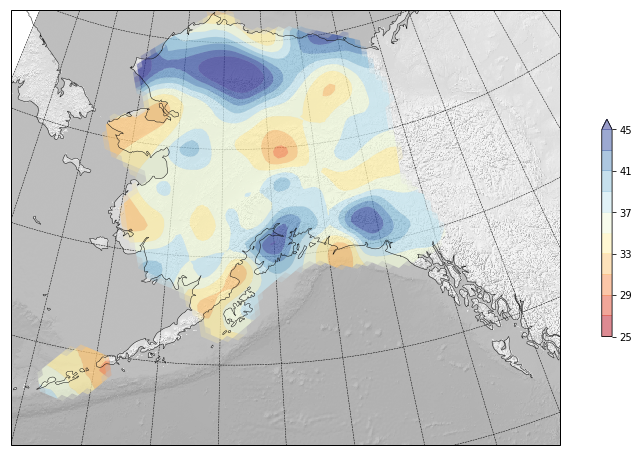

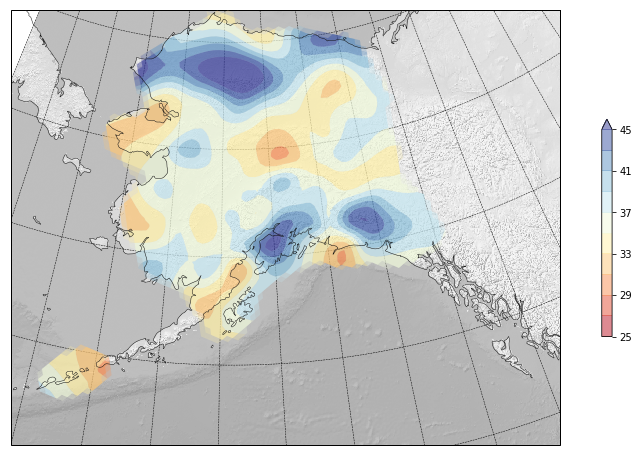

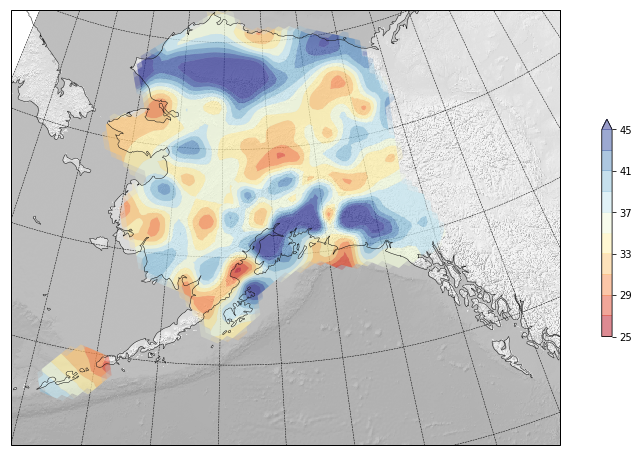

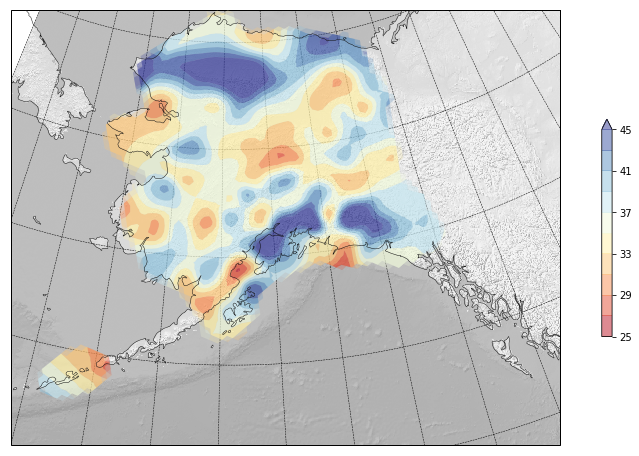

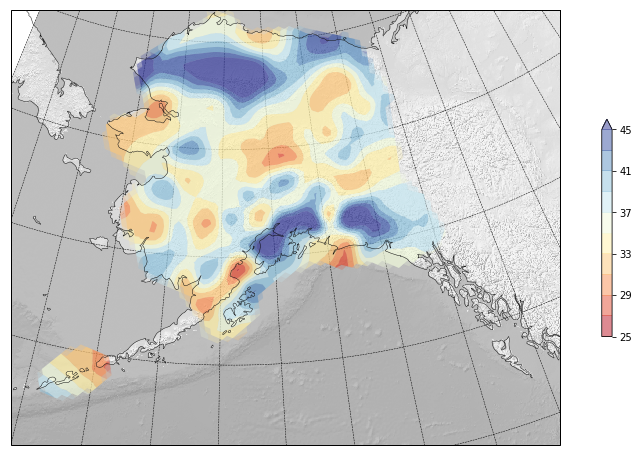

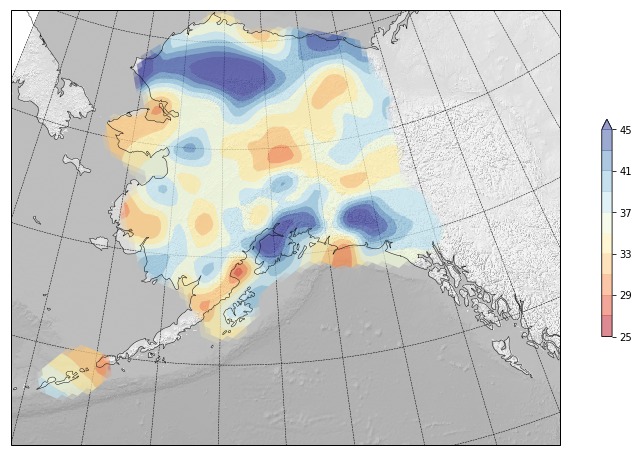

In [25]:
alaska_moho_plot("Images/{}-AlaskaMohoBest.png".format(Moho_data_filename), 
                 gridF, gridF_interpolation_best, 
                 interpolation_quality_d2, 
                 plot_range=[25, 45],
                 show_bg_image=True )

alaska_moho_plot("Images/{}-AlaskaMoho1pct.png".format(Moho_data_filename), 
                 gridF, gridF_opc, 
                 interpolation_quality_d2, 
                 plot_range=[25, 45],
                 show_bg_image=True )

alaska_moho_plot("Images/{}-AlaskaMohoBestM.png".format(Moho_data_filename), 
                 gridF, gridF_interpolation_bestm, 
                 interpolation_quality_d2, 
                 plot_range=[25, 45],
                 show_bg_image=True )

alaska_moho_plot("Images/{}-AlaskaMohoBestM1pct.png".format(Moho_data_filename), 
                 gridF, gridF_opc_m, 
                 interpolation_quality_d2, 
                 plot_range=[25, 45],
                 show_bg_image=True )

alaska_moho_plot("Images/{}-AlaskaMohoBestJ.png".format(Moho_data_filename), 
                 gridF, gridF_interpolation_bestj, 
                 interpolation_quality_d2, 
                 plot_range=[25, 45],
                 show_bg_image=True )

alaska_moho_plot("Images/{}-AlaskaMohoBestJ1pct.png".format(Moho_data_filename), 
                 gridF, gridF_opc_j, 
                 interpolation_quality_d2, 
                 plot_range=[25, 45],
                 show_bg_image=True )



In [26]:
def alaska_moho_slope_plot(filename, 
                           grid, 
                           data, 
                           grad,
                           quality, 
                           plot_range=[25.0, 50.0], 
                           show_coastline=True,
                           show_bg_image=True,
                           raw_data_points=None,
                           cmap=None ):
    
    goodgrid = grid
    interpolation_quality = quality
    grid_data = data
    grad_data = grad

    
    if cmap == None:
        cmap = plt.cm.Oranges
        
        
    try:   
        import gdal
        globalsrelief       = gdal.Open("../ShadedRelief/GRAY_HR_SR_OB.tif")
        globalsrelief_img   = globalsrelief.ReadAsArray()/255.0  # .transpose(1,2,0)
        globalsrelief_img_q = globalsrelief_img[0:globalsrelief_img.shape[0]/4, 0:globalsrelief_img.shape[1]/4]
    except ImportError:
        show_bg_image = False



    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-170,-130,50,70])

    if(show_bg_image):
        ax1.imshow(globalsrelief_img_q**0.5, origin='upper', transform=ccrs.PlateCarree(),
                   extent=[-180,-90,45,90], zorder=0, alpha=1.0, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)
    
    ax1.coastlines(resolution="50m",color="#111111", linewidth=0.5, zorder=99)


    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)
  
    gdata2 = grad_data.copy()
    gdata2[ quality == 0] = -1000000.0
 
    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmap, 
                   levels=np.linspace(0.0,0.15,16),
                   extend="max", linewidths=0.0,
                   transform=ccrs.PlateCarree(),
                         antialiased=True,
                         alpha=0.75,
                         zorder=10)
    
    centroids_q, err = gridF.interpolate(gridF.lons[gridF.simplices].mean(axis=1), 
                                    gridF.lats[gridF.simplices].mean(axis=1), quality)
    
    
    mask = centroids_q == 0.0

    cnt=ax1.tricontour(lons, lats, goodgrid.simplices, grid_data, 
                   alpha=1.0, colors="#000000", mask=mask,
                   levels=[25, 29, 33, 37, 41, 45],
                   linewidths=[0.5,0.5, 0.75, 0.75, 1.0, 1.0],
                   linestyles=[":","-"],
                   transform=ccrs.PlateCarree(), 
                       zorder=50) 
  
    ## Mask by "quality" of the interpolation

    
    ## Locations of raw data collection

    if(raw_data_points):
        m = ax1.scatter(raw_data_points['lon'], raw_data_points['lat'],  color="Black",
                       edgecolor="Black", linewidth=0.5, 
                       marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )

    fig.savefig(filename, dpi=300)
 
    return

/usr/local/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'mask'
  s)


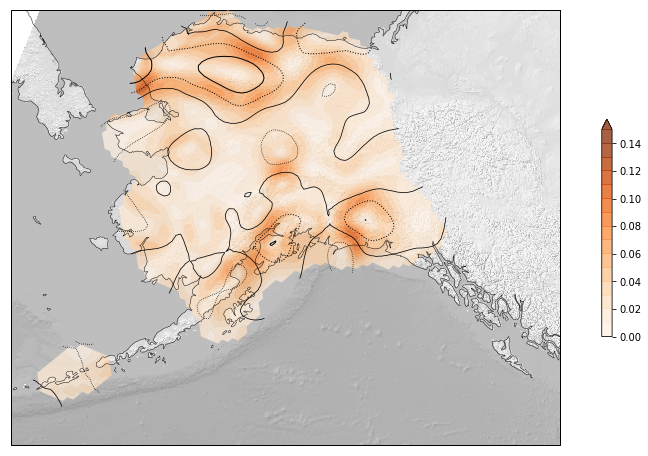

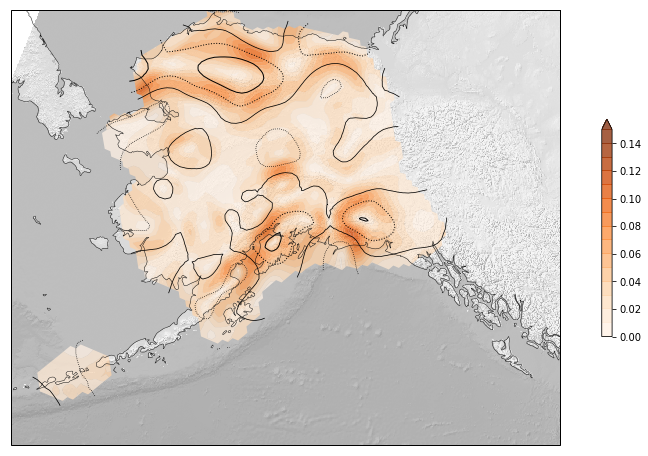

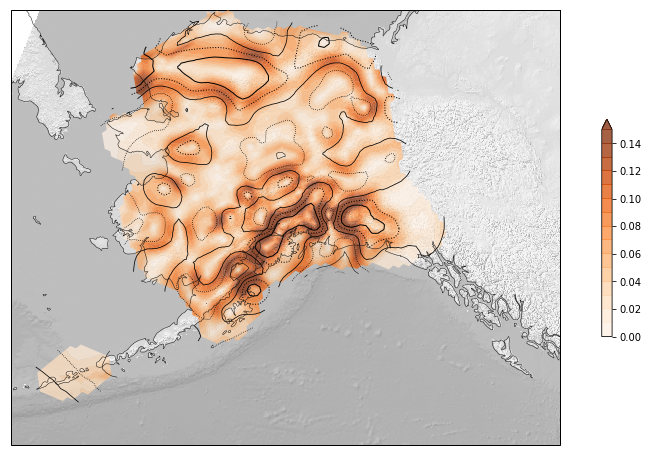

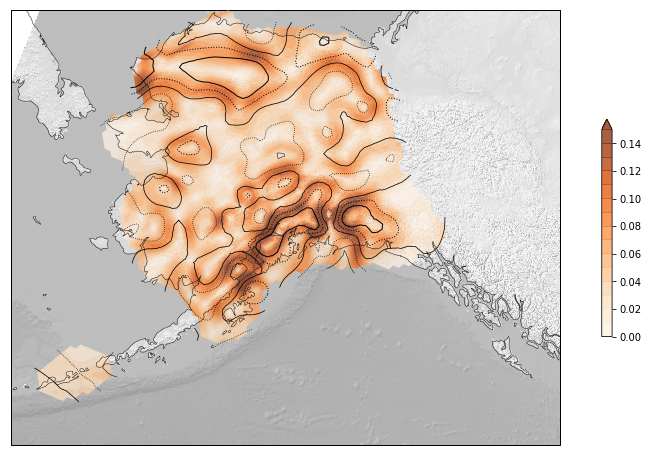

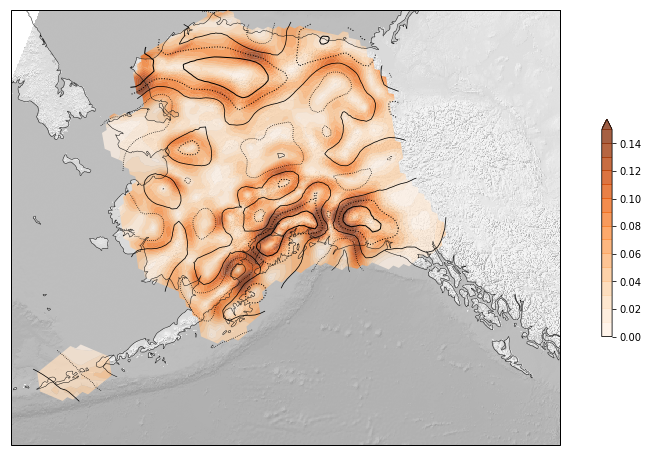

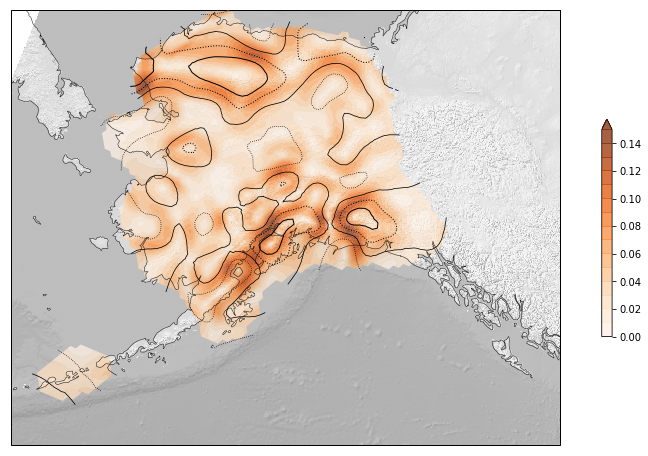

In [27]:
alaska_moho_slope_plot("Images/{}-AlaskaMohoSlopeBest.png".format(Moho_data_filename), 
                        gridF, gridF_interpolation_best, 
                        gridF_interpolation_best_s/6371,
                        interpolation_quality_d2, 
                        plot_range=[25, 45],
                        show_bg_image=True )


alaska_moho_slope_plot("Images/{}-AlaskaMohoSlopeBest_1pct.png".format(Moho_data_filename), 
                        gridF, gridF_opc, 
                        gridF_opc_s/6371,
                        interpolation_quality_d2, 
                        plot_range=[25, 45],
                        show_bg_image=True )

## == 

alaska_moho_slope_plot("Images/{}-AlaskaMohoSlopeBestM.png".format(Moho_data_filename), 
                        gridF, gridF_interpolation_bestm, 
                        gridF_interpolation_bestm_s/6371,
                        interpolation_quality_d2, 
                        plot_range=[25, 45],
                        show_bg_image=True )

alaska_moho_slope_plot("Images/{}-AlaskaMohoSlopeBestM_1pct.png".format(Moho_data_filename), 
                        gridF, gridF_opc_m, 
                        gridF_opc_m_s/6371,
                        interpolation_quality_d2, 
                        plot_range=[25, 45],
                        show_bg_image=True )

## ==

alaska_moho_slope_plot("Images/{}-AlaskaMohoSlopeBestJ.png".format(Moho_data_filename), 
                        gridF, gridF_interpolation_bestj, 
                        gridF_interpolation_bestj_s/6371,
                        interpolation_quality_d2, 
                        plot_range=[25, 45],
                        show_bg_image=True )



alaska_moho_slope_plot("Images/{}-AlaskaMohoSlopeBestJ_1pct.png".format(Moho_data_filename), 
                        gridF, gridF_opc_j, 
                        gridF_opc_j_s/6371,
                        interpolation_quality_d2, 
                        plot_range=[25, 45],
                        show_bg_image=True )


In [28]:
np.savez("Models/{}-AlaskaMohoFineGrid.npz".format(Moho_data_filename),
         gridlons=gridF.lons, 
         gridlats=gridF.lats, 
         gridded_data_1=gridF_opc_j,
         gridded_data_slope_1=gridF_opc_j_s,
         gridded_data_2=gridF_interpolation_best,
         gridded_data_slope_2=gridF_interpolation_best_s,
         gridded_data_3=gridF_interpolation_bestm,
         gridded_data_slope_3=gridF_interpolation_bestm_s,     
         quality=interpolation_quality_d2)

In [29]:
## Regular grid of lon/lat values for "easy" GMT plotting


ax.set_extent([-175,-130,50,72])

lons = np.linspace(-175,-130,256)
lats = np.linspace(50, 72, 256)

reg_lons, reg_lats = np.meshgrid(lons, lats)

quality, err = gridF.interpolate(np.radians(reg_lons.reshape(-1)), np.radians(reg_lats.reshape(-1)), 
                                 interpolation_quality_d2, order=1)

reg_moho, err = gridF.interpolate(np.radians(reg_lons.reshape(-1)), np.radians(reg_lats.reshape(-1)), 
                               gridF_opc_j, order=3)


a = np.transpose(np.stack((reg_lons.reshape(-1), 
                           reg_lats.reshape(-1), 
                           reg_moho.reshape(-1), 
                           quality.reshape(-1))))

np.savetxt("Models/{}-RegGridMoho.XYZ".format(Moho_data_filename), a, header="Longitude Latitude Depth Quality")


In [30]:
## Gradient of this one ... 

slope, err = gridF.interpolate(np.radians(reg_lons.reshape(-1)), np.radians(reg_lats.reshape(-1)), 
                               gridF_opc_j_s, order=3)


a = np.transpose(np.stack((reg_lons.reshape(-1), 
                           reg_lats.reshape(-1), 
                           slope.reshape(-1) / 6371, 
                           quality.reshape(-1))))

np.savetxt("Models/{}-RegGridMohoSlope.XYZ".format(Moho_data_filename), a, header="Longitude Latitude Slope Quality")



In [31]:
print gridF_interpolation_best.min(), gridF_interpolation_best.max()
print reg_moho.min(), reg_moho.max()

1.7430798386415867 58.165549997126824
-32.947868739693945 61.30950334241163


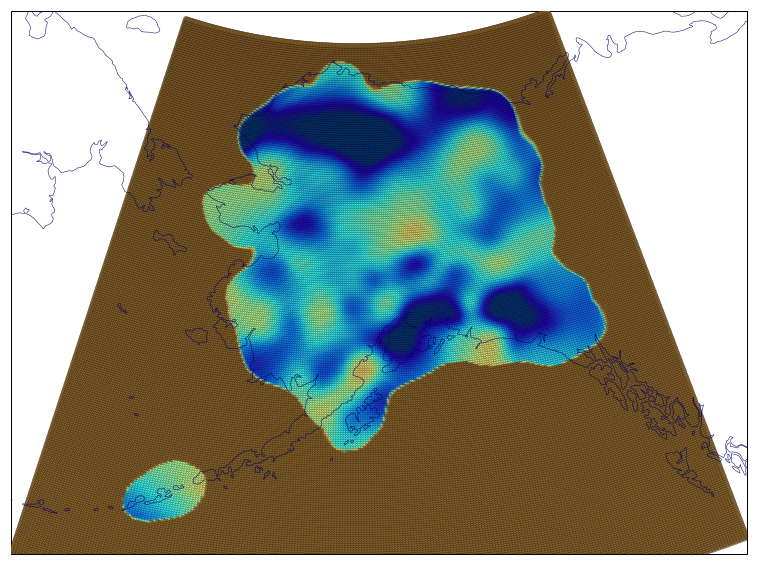

In [32]:
fig = plt.figure(figsize=(20, 10), facecolor="none")
ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))

ax1.set_extent([-175,-130,50,72])

# ax.set_global()

ax1.coastlines(resolution="50m",color="#000066", linewidth=0.5, zorder=100)

ax1.scatter(reg_lons, reg_lats, 
                c=(reg_moho*np.minimum(1.0,quality/quality.mean())).reshape(reg_lons.shape), 
                cmap=msmcmap2, # plt.cm.Oranges,
                edgecolor="Black", linewidth=0.25,
                alpha=0.8, vmin=25.0, vmax=45,
                marker="o", s=25.0, transform=ccrs.Geodetic(), zorder=10)


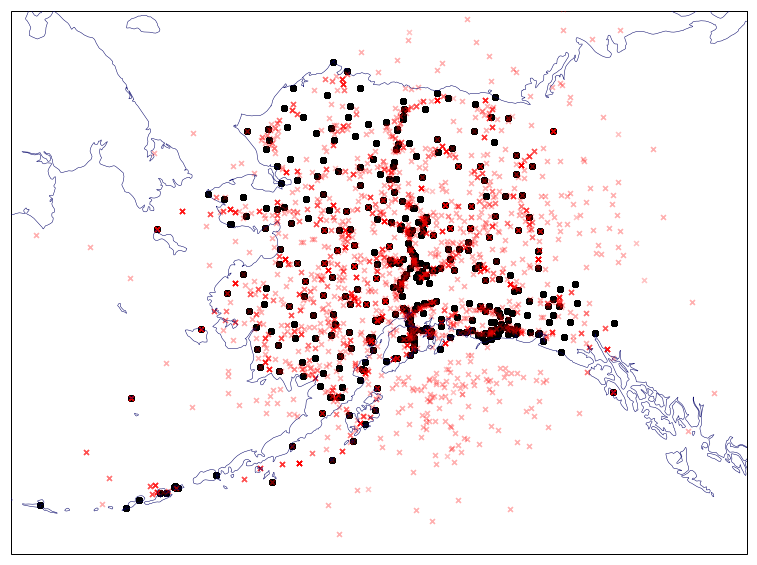

In [33]:
fig = plt.figure(figsize=(20, 10), facecolor="none")
ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))

ax1.set_extent([-175,-130,50,72])

# ax.set_global()

ax1.coastlines(resolution="50m",color="#000066", linewidth=0.5, zorder=100)


for e in range(0, grid_realisations, 1):
    
    dlons = np.degrees(grid_ensemble[e][100].lons)%360.0
    dlats = np.degrees(grid_ensemble[e][100].lats)
    
    
    ax1.scatter(dlons, dlats, marker="x",  color="#FF000008",     
                s=25.0, transform=ccrs.Geodetic(), zorder=10)
    
    ax1.scatter(moho_data_all['lon'], moho_data_all['lat'], color="#000000",
               s=25.0,marker="o", transform=ccrs.Geodetic())

